In [1]:
import numpy as np
import GEOparse as gp
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn
import combat
import math
#from combat.pycombat import pycombat

We download the data from the GSE dataset

In [2]:
gse1 = gp.get_GEO(geo="GSE157239", destdir="./")
gse2 = gp.get_GEO(geo="GSE147232", destdir="./")

06-Dec-2020 02:09:11 DEBUG utils - Directory ./ already exists. Skipping.
06-Dec-2020 02:09:11 INFO GEOparse - File already exist: using local version.
06-Dec-2020 02:09:11 INFO GEOparse - Parsing ./GSE157239_family.soft.gz: 
06-Dec-2020 02:09:11 DEBUG GEOparse - DATABASE: GeoMiame
06-Dec-2020 02:09:11 DEBUG GEOparse - SERIES: GSE157239
06-Dec-2020 02:09:11 DEBUG GEOparse - PLATFORM: GPL21572
/usr/local/lib/python3.9/site-packages/GEOparse/GEOparse.py:110: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  return parse_GSE(filepath, open_kwargs=open_kwargs)
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759790
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759791
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759792
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759793
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759794
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE: GSM4759795
06-Dec-2020 02:09:15 DEBUG GEOparse - SAMPLE

In [67]:
# Significance level
alpha2 = 0.01

# Identifying which samples are controls
control_columns2 = np.array([0, 1, 2, 3, 4])
c2 = np.zeros(10, dtype=bool)
c2[control_columns2] = 1

#print(gse2.gsms)
values2 = []
for _, v in gse2.gsms.items():
    ids2 = v.table["ID_REF"].to_numpy()
    values2.append(v.table['VALUE'].to_numpy())
values2 = np.stack(values2, axis=-1)

# Getting rid of the NaNs in the values array
nan_array = []
print(len(values2[:, 0]))
for i in np.arange(len(values2[:, 0])):
    for j in np.arange(len(values2[0, :])):
        if np.isnan(values2[i, j]):
            nan_array.append(i)

values2 = np.delete(values2, nan_array, axis = 0) 
ids2 = np.delete(ids2, nan_array, axis = 0)

raw_data2 = gse2.gpls['GPL18058'].table
raw_data2 = raw_data2[pd.notna(raw_data2['Human_miRNA'])]
raw_ids2 = raw_data2['ID'].to_numpy()

mirna_idxs2 = [i for i, x in enumerate(ids2) if np.any(raw_ids2 == x)]
mirna_ids2 = ids2[mirna_idxs2]
values2 = values2[mirna_idxs2]


raw_data2_masks = [raw_data2['ID'].to_numpy() == id for id in mirna_ids2]
end_mask = None
for raw_data2_mask in raw_data2_masks:
    end_mask = raw_data2_mask if end_mask is None else (end_mask | raw_data2_mask)

raw_data2 = raw_data2[end_mask]
print(raw_data2.shape)
print(values2.shape)

mask2 = np.broadcast_to(c2, (len(values2), 10))

controls2 = values2[mask2].reshape(-1, 5)
samples2 = values2[~mask2].reshape(-1, 5)

# Running one-way ANOVA analysis on the RNAs
f_stats2 = stats.f_oneway(controls2, samples2, axis=-1)
num_significant2 = np.sum(f_stats2.pvalue < alpha2)
signif_ids2 = mirna_ids2[f_stats2.pvalue < alpha2]

# Sorting by p-value
ids2 = np.array(ids2)
order2 = np.argsort(f_stats2.pvalue)
sorted_ids2 = ids2[order2]

sorted_pvalues2 = np.copy(f_stats2.pvalue)
sorted_pvalues2.sort()

3556
(2135, 9)
(2135, 10)


Text(0, 0.5, 'Frequency')

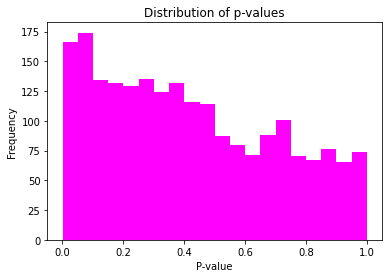

In [89]:
signifs2 = []
mirna_signif_ids2 = []
for sig_id2 in signif_ids2:
    if not any(raw_data2["ID"] == sig_id2):
        continue
    signifs2.append(raw_data2[raw_data2["ID"] == sig_id2])
    mirna_signif_ids2.append(sig_id2)

signifs2 = pd.concat(signifs2)
mirna_signif_id_mask2 = [np.nonzero(mirna_ids2 == i)[0][0] for i in mirna_signif_ids2] #watch

signifs2.insert(0, "P-value", f_stats2.pvalue[mirna_signif_id_mask2])

signif_indices2 = []
for i in np.arange(len(f_stats2.pvalue)):
    if f_stats2.pvalue[i] < alpha2:
        signif_indices2.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues2, bins = 20, color = 'magenta')
plt.title('Distribution of p-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')

#mirna_mask2 = signifs2['Sequence Type'] == 'miRNA'
#mirna_signifs2 = signifs2[mirna_mask]

In [92]:
regulations2 = np.mean(samples2, axis=-1) > np.mean(controls2, axis=-1)

# True if upregulated, False if downregulated
signif_regulations2 = regulations2[mirna_signif_id_mask2]

signif_names2 = signifs2['Human_miRNA'].to_numpy()

labeled_sig_regs2 = np.stack([
    signif_names2,
    signif_regulations2
], axis=-1)

print(labeled_sig_regs2)


[['hsa-miR-561-3p' False]
 ['hsa-miR-5194' True]
 ['hsa-miR-554' False]
 ['hsa-miR-4326' False]
 ['hsa-miR-4790-3p' False]
 ['hsa-miR-4745-3p' False]
 ['hsa-miR-518d-3p' False]
 ['hsa-miR-3921' False]
 ['hsa-miR-5583-5p' False]
 ['hsa-miR-5686' False]
 ['spike_control_v2_5' False]
 ['hsa-miR-3620' False]
 ['hsa-miR-3177-5p' False]
 ['hsa-miR-200c-5p' False]
 ['hsa-miR-548c-3p' False]
 ['hsa-miR-3687' False]
 ['hsa-miR-5188' False]
 ['hsa-miR-548x-3p' False]
 ['hsa-miR-5708' False]
 ['hsv1-miR-H17' False]
 ['hsa-miR-4747-5p' True]
 ['spike_control_v1_d' False]
 ['hsa-miR-196a-3p' False]
 ['spike_control_v2_1' False]
 ['hsa-let-7e-3p' False]
 ['hsa-miR-3678-3p' False]
 ['hsa-miR-5196-5p' False]
 ['hsa-miR-4638-5p' False]
 ['hsa-miR-4474-5p' False]
 ['hsv2-miR-H11' False]
 ['hsa-miR-938' False]
 ['hsa-miR-1909-3p' False]
 ['hsa-miR-4297' True]
 ['hsa-miR-1273g-5p' False]
 ['hsa-miR-4722-5p' True]
 ['spike_control_v2_23' False]
 ['hsa-miR-3200-3p' True]
 ['hsa-miR-4668-3p' False]]


In [6]:
# Normalizing data for clustering
values_norm2 = values2

values_norm2 = values_norm2 - np.mean(values_norm2, axis=-1, keepdims=True)
values_norm2 = values_norm2 / np.std(values_norm2, axis=-1, keepdims=True)

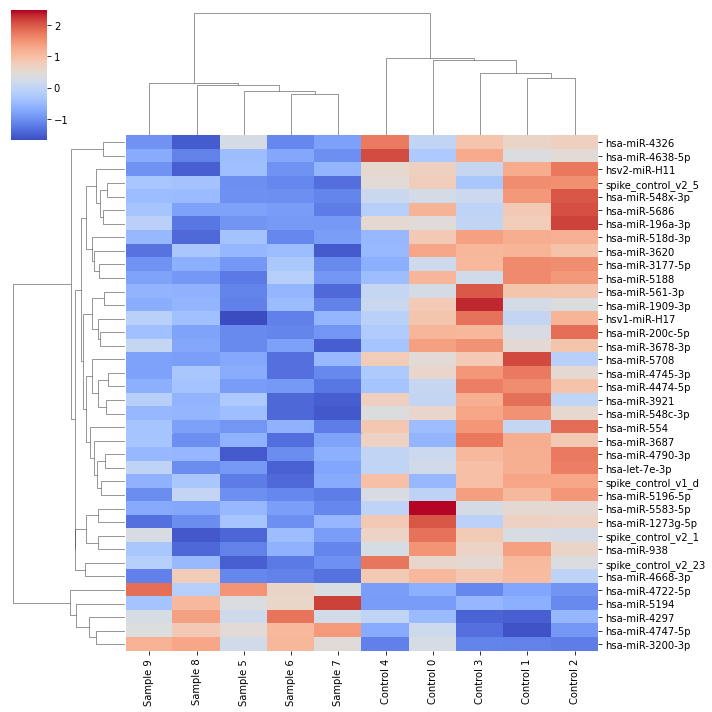

In [7]:
# Clustermap
dendro_df2 = pd.DataFrame(values_norm2[mirna_signif_id_mask2])
dendro_df2.columns = [('Control ' if i in control_columns2 else 'Sample ') + str(i) for i in range(10)]
dendro_df2.index = list(signifs2['Human_miRNA'])
display(seaborn.clustermap(dendro_df2, cmap='coolwarm'))

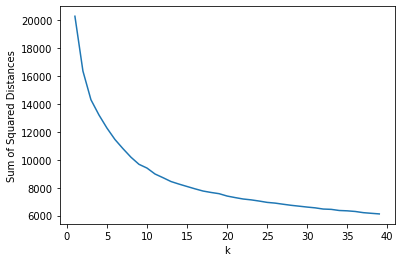

In [8]:
# K-means clustering
sum_of_squared_distances2 = []
for k in range(1, 40):
    kmeans2 = KMeans(n_clusters = k).fit(values_norm2)
    sum_of_squared_distances2.append(kmeans2.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances2)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [9]:
kmeans2 = KMeans(n_clusters = 8).fit(values_norm2)

#argmin, distance = sklearn.metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, values_norm)
#print(ids[argmin])

signif_labels_list2 = kmeans2.labels_[signif_indices2]
mirna_signif_labels_list2 = signif_labels_list2[0:38]

print(mirna_signif_labels_list2)

[0 5 2 1 2 0 0 0 3 2 2 0 2 2 0 0 2 2 7 0 5 0 2 3 2 0 0 1 0 2 3 0 5 3 6 0 5
 0]


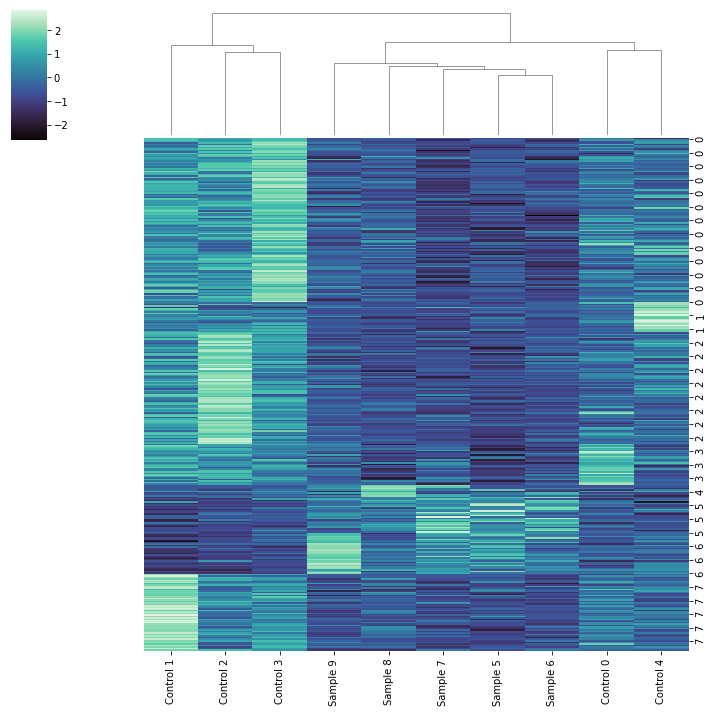

In [10]:
signif_level2 = 0.1
order2 = np.argsort(kmeans2.labels_[f_stats2.pvalue < signif_level2])
clustered_values2 = values_norm2[f_stats2.pvalue < signif_level2][order2]
value_df2 = pd.DataFrame(clustered_values2)
value_df2.index = kmeans2.labels_[f_stats2.pvalue < signif_level2][order2]
value_df2.columns = [('Control ' if i in control_columns2 else 'Sample ') + str(i) for i in range(10)]
seaborn.clustermap(value_df2, cmap='mako', row_cluster=False, col_cluster=True)

In [100]:
# Significance level
alpha = 0.01

# Identifying which samples are controls
control_columns = np.array([0, 1, 2, 4, 6, 9, 11, 15])
c = np.zeros(16, dtype=bool)
c[control_columns] = 1

# Creating accessible matrices from the dataset
values = []
for k, v in gse1.gsms.items():
    ids = v.table["ID_REF"].to_numpy()
    values.append(v.table['VALUE'].to_numpy())
values = np.stack(values, axis=-1)

raw_data = gse1.gpls['GPL21572'].table
raw_data = raw_data[raw_data['Sequence Type'] == 'miRNA']
raw_ids = raw_data['ID'].to_numpy()
mirna_idxs = [i for i, x in enumerate(ids) if np.any(raw_ids == x)]
mirna_ids = ids[mirna_idxs]
values = values[mirna_idxs]
print("Number of miRNA samples", values.shape[0])

raw_data_masks = [raw_data['ID'].to_numpy() == id for id in mirna_ids]
end_mask = None
for raw_data_mask in raw_data_masks:
    end_mask = raw_data_mask if end_mask is None else (end_mask | raw_data_mask)

raw_data = raw_data[end_mask]

mask = np.broadcast_to(c, (len(values), 16))

controls = values[mask].reshape(-1, 8)
samples = values[~mask].reshape(-1, 8)

# Running one-way ANOVA analysis on the RNAs
f_stats = stats.f_oneway(controls, samples, axis=-1)
num_significant = np.sum(f_stats.pvalue < alpha)
signif_ids = mirna_ids[f_stats.pvalue < alpha]

# Sorting by p-value
ids = np.array(ids)
order = np.argsort(f_stats.pvalue)
sorted_ids = ids[order]

Number of miRNA samples 2578
(2578, 17)


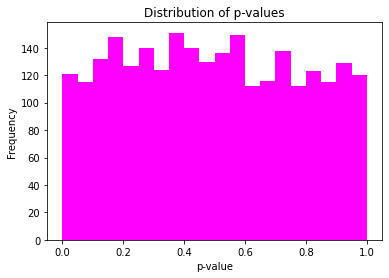

In [12]:
signifs = []
mirna_signif_ids = []
for sig_id in signif_ids:
    if not any(raw_data["ID"] == sig_id):
        continue
    signifs.append(raw_data[raw_data["ID"] == sig_id])
    mirna_signif_ids.append(sig_id)

signifs = pd.concat(signifs)
mirna_signif_id_mask = [np.nonzero(ids == i)[0][0] for i in mirna_signif_ids]
signifs.insert(17, "P-value", f_stats.pvalue[mirna_signif_id_mask])

sorted_pvalues = np.copy(f_stats.pvalue)
sorted_pvalues.sort()

signif_indices = []
for i in np.arange(len(f_stats.pvalue)):
    if f_stats.pvalue[i] < alpha:
        signif_indices.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues, bins = 20, color = 'magenta')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')

mirna_mask = signifs['Sequence Type'] == 'miRNA'
mirna_signifs = signifs[mirna_mask]

To determine if each gene is upregulated or downregulated, we compare the mean values against the control.

In [13]:
regulations = np.mean(samples, axis=-1) > np.mean(controls, axis=-1)

# True if upregulated, False if downregulated
signif_regulations = regulations[mirna_signif_id_mask]

labeled_sig_regs = np.stack([
    signifs['Transcript ID(Array Design)'].to_numpy(),
    signif_regulations
], axis=-1)

In [27]:
# Creating table of p-values, regulation patterns, and functions of each miRNA of interest
data = {'P-value': signifs['P-value'].values, 
        'Regulation (case vs. control)':['Upregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Upregulated', 
                                         'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated'], 
        'Function':['Tumor suppression', 'Cell proliferation', 'Tumor suppression', 'DNA methylation', 'Regulates A\u03B2', 'Cell proliferation', 'Cell proliferation', 'Cell proliferation',
                   'Tumor suppression', 'Tumor suppression', 'Lipid metabolism', 'N/A', 'N/A', 'N/A', 'Tumor suppression', 'N/A', 'N/A', 'N/A', 'N/A', 'Regulate autoimmune disease']} 

signif_names = ['miR-215-3p', 'miR-369-5p', 'miR-429', 'miR-767-5p', 'miR-1251-5p', 'miR-1470', 'miR-3180-5p', 'miR-4286', 'miR-500b-3p', 'miR-3912-5p', 'miR-3929', 'miR-4540', 'miR-4633-3p',
                               'miR-4653-5p', 'miR-203b-5p', 'miR-4791', 'miR-5003-3p', 'miR-5093', 'miR-6877-5p', 'miR-7155-3p']
df = pd.DataFrame(data, index=signif_names)

display(df)


,P-value,Regulation (case vs. control),Function
miR-215-3p,0.008630,Upregulated,Tumor suppression
miR-369-5p,0.003104,Downregulated,Cell proliferation
miR-429,0.007773,Upregulated,Tumor suppression
miR-767-5p,0.006993,Downregulated,DNA methylation
miR-1251-5p,0.009721,Downregulated,Regulates Aβ
miR-1470,0.009135,Upregulated,Cell proliferation
miR-3180-5p,0.002045,Downregulated,Cell proliferation
miR-4286,0.000047,Downregulated,Cell proliferation
miR-500b-3p,0.001586,Downregulated,Tumor suppression
miR-3912-5p,0.002591,Upregulated,Tumor suppression


In [15]:
# Normalizing data for clustering
values_norm = values

values_norm = values_norm - np.mean(values_norm, axis=-1, keepdims=True)
values_norm = values_norm / np.std(values_norm, axis=-1, keepdims=True)

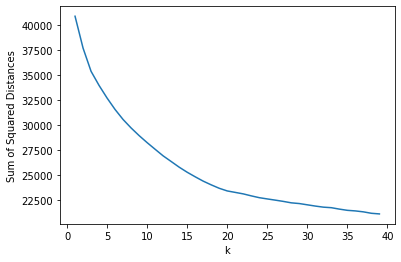

In [16]:
# K-means clustering
sum_of_squared_distances = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters = k).fit(values_norm)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [17]:
kmeans = KMeans(n_clusters = 8).fit(values_norm)

#argmin, distance = sklearn.metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, values_norm)
#print(ids[argmin])

signif_labels_list = kmeans.labels_[signif_indices]
mirna_signif_labels_list = signif_labels_list[0:20]

print(mirna_signif_labels_list)

[1 6 5 6 3 5 4 2 4 1 5 5 5 5 1 3 3 3 4 3]


In [18]:
# Here we analyze the functions within each cluster above
unknown_idxs = [mirna_signif_id_mask[i] for i in range(len(mirna_signif_id_mask)) if list(df['Function'])[i] == 'N/A']
unknown_clusters = [mirna_signif_labels_list[i] for i in range(len(mirna_signif_id_mask)) if list(df['Function'])[i] == 'N/A']

num_nearest = 3

for unknown_idx, cluster in zip(unknown_idxs, unknown_clusters):
    print(f"Nearest items in cluster {cluster} with {raw_data['Transcript ID(Array Design)'][raw_data['ID'] == mirna_ids[unknown_idx]].item()}")
    in_cluster = (kmeans.labels_ == cluster)
    cluster_center = kmeans.cluster_centers_[cluster]
    
    distances_to_center = values_norm[in_cluster] @ cluster_center
    closest = np.argsort(distances_to_center)[-num_nearest:]
    near_ids = mirna_ids[in_cluster][closest]
    near = [raw_data[raw_data['ID'] == near_id] for near_id in near_ids]
    display(pd.concat(near))



Nearest items in cluster 5 with hsa-miR-4540


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18436,20518436,MIMAT0019225_st,MIMAT0019225,hsa-miR-3913-3p,miRNA,Homo sapiens,chr12:69978524-69978545 (-) /// chr12:69978560...,22,AGACAUCAAGAUCAGUCCCAAA,ENST00000577744 // antisense // exon // 1,hsa-mir-3913-1 // chr12:69978502-69978603 (-) ...,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3913-3p,NaN
6891,20506891,MIMAT0005945_st,MIMAT0005945,hsa-miR-1255b-5p,miRNA,Homo sapiens,chr1:167967903-167967924 (+) /// chr4:36428027...,22,CGGAUGAGCAAAGAAAGUGGUU,ENST00000312263 // sense // intron // 7 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-1255b-5p,NaN
19470,20519470,MIMAT0019752_st,MIMAT0019752,hsa-miR-4671-5p,miRNA,Homo sapiens,chr1:234442222-234442243 (+),22,ACCGAAGACUGUGCGCUAAUCU,ENST00000366617 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4671-5p,NaN


Nearest items in cluster 5 with hsa-miR-4633-3p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18436,20518436,MIMAT0019225_st,MIMAT0019225,hsa-miR-3913-3p,miRNA,Homo sapiens,chr12:69978524-69978545 (-) /// chr12:69978560...,22,AGACAUCAAGAUCAGUCCCAAA,ENST00000577744 // antisense // exon // 1,hsa-mir-3913-1 // chr12:69978502-69978603 (-) ...,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3913-3p,NaN
6891,20506891,MIMAT0005945_st,MIMAT0005945,hsa-miR-1255b-5p,miRNA,Homo sapiens,chr1:167967903-167967924 (+) /// chr4:36428027...,22,CGGAUGAGCAAAGAAAGUGGUU,ENST00000312263 // sense // intron // 7 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-1255b-5p,NaN
19470,20519470,MIMAT0019752_st,MIMAT0019752,hsa-miR-4671-5p,miRNA,Homo sapiens,chr1:234442222-234442243 (+),22,ACCGAAGACUGUGCGCUAAUCU,ENST00000366617 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4671-5p,NaN


Nearest items in cluster 5 with hsa-miR-4653-5p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18436,20518436,MIMAT0019225_st,MIMAT0019225,hsa-miR-3913-3p,miRNA,Homo sapiens,chr12:69978524-69978545 (-) /// chr12:69978560...,22,AGACAUCAAGAUCAGUCCCAAA,ENST00000577744 // antisense // exon // 1,hsa-mir-3913-1 // chr12:69978502-69978603 (-) ...,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3913-3p,NaN
6891,20506891,MIMAT0005945_st,MIMAT0005945,hsa-miR-1255b-5p,miRNA,Homo sapiens,chr1:167967903-167967924 (+) /// chr4:36428027...,22,CGGAUGAGCAAAGAAAGUGGUU,ENST00000312263 // sense // intron // 7 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-1255b-5p,NaN
19470,20519470,MIMAT0019752_st,MIMAT0019752,hsa-miR-4671-5p,miRNA,Homo sapiens,chr1:234442222-234442243 (+),22,ACCGAAGACUGUGCGCUAAUCU,ENST00000366617 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4671-5p,NaN


Nearest items in cluster 3 with hsa-miR-4791


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1155,20501155,MIMAT0004671_st,MIMAT0004671,hsa-miR-194-3p,miRNA,Homo sapiens,chr11:64658840-64658861 (-),22,CCAGUGGGGCUGCUGUUAUCUG,ENST00000413053 // sense // exon // 2 /// OTTH...,hsa-mir-192 // chr11:64658609-64658718 (-) ///...,microcosm // ENST00000004921 // CCL18 /// micr...,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-194-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 3 with hsa-miR-5003-3p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1155,20501155,MIMAT0004671_st,MIMAT0004671,hsa-miR-194-3p,miRNA,Homo sapiens,chr11:64658840-64658861 (-),22,CCAGUGGGGCUGCUGUUAUCUG,ENST00000413053 // sense // exon // 2 /// OTTH...,hsa-mir-192 // chr11:64658609-64658718 (-) ///...,microcosm // ENST00000004921 // CCL18 /// micr...,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-194-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 3 with hsa-miR-5093


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1155,20501155,MIMAT0004671_st,MIMAT0004671,hsa-miR-194-3p,miRNA,Homo sapiens,chr11:64658840-64658861 (-),22,CCAGUGGGGCUGCUGUUAUCUG,ENST00000413053 // sense // exon // 2 /// OTTH...,hsa-mir-192 // chr11:64658609-64658718 (-) ///...,microcosm // ENST00000004921 // CCL18 /// micr...,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-194-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 4 with hsa-miR-6877-5p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
177,20500177,MIMAT0000095_st,MIMAT0000095,hsa-miR-96-5p,miRNA,Homo sapiens,chr7:129414579-129414601 (-),23,UUUGGCACUAGCACAUUUUUGCU,---,hsa-mir-96 // chr7:129414532-129414609 (-) ///...,MTI // --- // PAQR4 /// miRecords // BC032946 ...,NaN,NaN,NaN,hsa-miR-96-5p,NaN
19706,20519706,MIMAT0019983_st,MIMAT0019983,hsa-miR-4803,miRNA,Homo sapiens,chr5:71465303-71465323 (+),21,UAACAUAAUAGUGUGGAUUGA,ENST00000296755 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4803,NaN
4308,20504308,MIMAT0003246_st,MIMAT0003246,hsa-miR-581,miRNA,Homo sapiens,chr5:53247394-53247414 (-),21,UCUUGUGUUCUCUAGAUCAGU,ENST00000502271 // sense // intron // 4 /// EN...,---,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-581,NaN


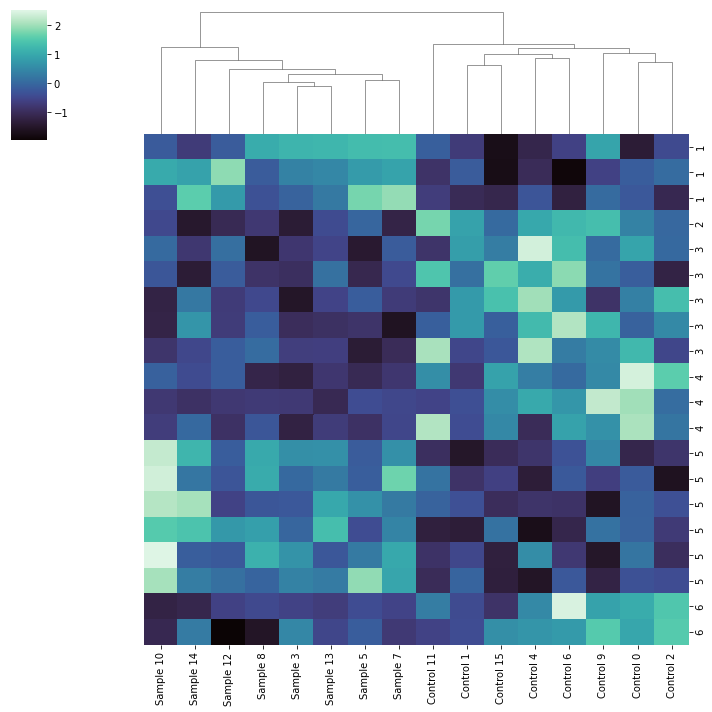

In [19]:
signif_level = 0.01
order = np.argsort(kmeans.labels_[f_stats.pvalue < signif_level])
clustered_values = values_norm[f_stats.pvalue < signif_level][order]
value_df = pd.DataFrame(clustered_values)
value_df.index = kmeans.labels_[f_stats.pvalue < signif_level][order]
value_df.columns = [('Control ' if i in control_columns else 'Sample ') + str(i) for i in range(16)]
seaborn.clustermap(value_df, cmap='mako', row_cluster=False, col_cluster=True)


In [20]:
# PCA
pca = PCA(n_components = 16)
pca.fit(values_norm)
print(pca.explained_variance_ratio_)

[1.18051727e-01 1.05219994e-01 8.19213453e-02 7.52271505e-02
 7.08612215e-02 6.64307877e-02 6.17752883e-02 5.88322093e-02
 5.81017094e-02 5.53891636e-02 5.32560700e-02 5.23602788e-02
 5.00342051e-02 4.81427581e-02 4.43960912e-02 9.26867810e-31]


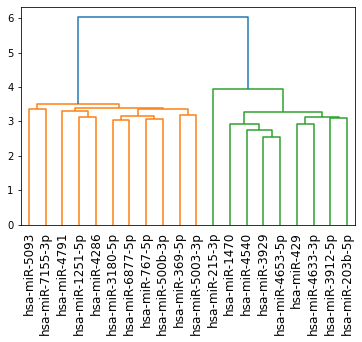

In [21]:
clustering = linkage(values_norm[mirna_signif_id_mask])
fig = plt.figure()

dendrogram(
    clustering,
    labels = list(signifs['Transcript ID(Array Design)']),
    leaf_rotation=90,
)

plt.show()

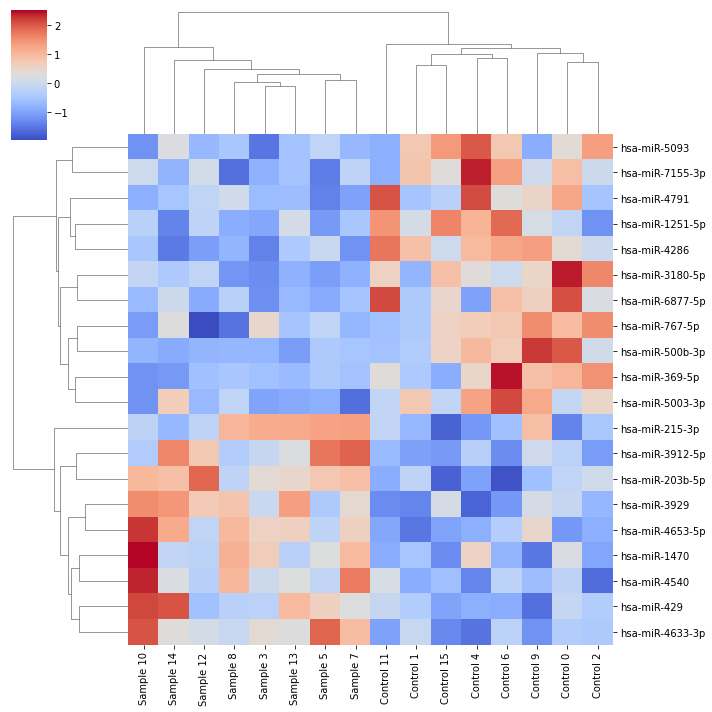

In [22]:
dendro_df = pd.DataFrame(values_norm[mirna_signif_id_mask])
dendro_df.columns = [('Control ' if i in control_columns else 'Sample ') + str(i) for i in range(16)]
dendro_df.index = list(signifs['Transcript ID(Array Design)'])
display(seaborn.clustermap(dendro_df, cmap='coolwarm'))

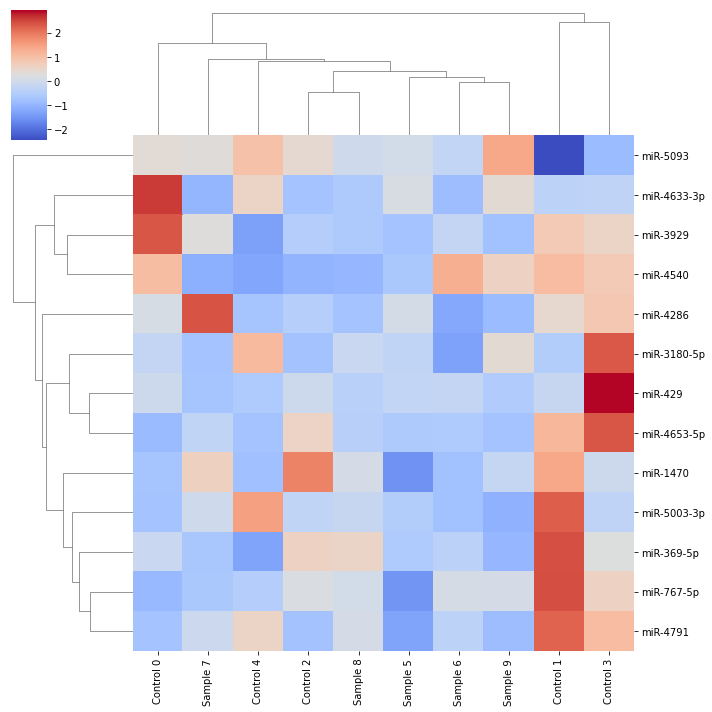

In [87]:
idxs = [raw_data2['Human_miRNA'].to_numpy() == ('hsa-' + name) for name in signif_names]
end_mask = idxs[0]
for mask in idxs[1:]:
    end_mask |= mask
dendro_df = pd.DataFrame(values_norm2[end_mask])

dendro_df.columns = [('Control ' if i in control_columns2 else 'Sample ') + str(i) for i in range(10)]
dendro_df.index = [name for name in signif_names if np.any(raw_data2['Human_miRNA'].to_numpy() == ('hsa-' + name))]
display(seaborn.clustermap(dendro_df, cmap='coolwarm'))

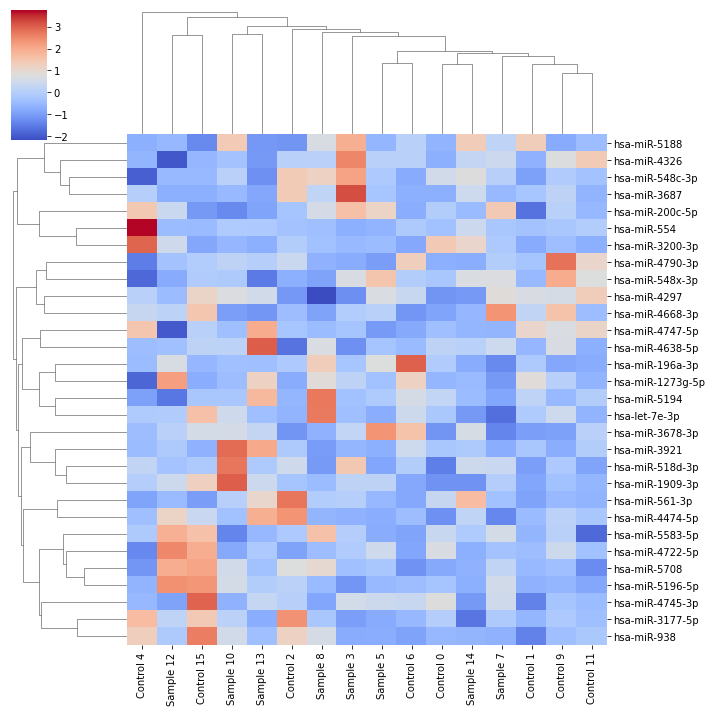

In [112]:
idxs = [raw_data['Transcript ID(Array Design)'].to_numpy() == name for name in signif_names2]
end_mask = idxs[0]
for mask in idxs[1:]: end_mask |= mask
dendro_df = pd.DataFrame(values_norm[end_mask])


dendro_df.columns = [('Control ' if i in control_columns else 'Sample ') + str(i) for i in range(16)]
dendro_df.index = [name for name in signif_names2 if np.any(raw_data['Transcript ID(Array Design)'].to_numpy() == name)]
display(seaborn.clustermap(dendro_df, cmap='coolwarm'))

In [23]:
# COMBAT

gene_names_1 = [raw_data[raw_data['ID'] == id]['Transcript ID(Array Design)'].item() for id in mirna_ids]

gene_names_2 = [raw_data2[raw_data2['ID'] == id]['Human_miRNA'].item() for id in mirna_ids2]

combat_1 = pd.DataFrame(data = values)
combat_1.columns = {'GSM4759790', 'GSM4759791', 'GSM4759792', 'GSM4759793', 
                     'GSM4759794', 'GSM4759795', 'GSM4759796', 'GSM4759797', 'GSM4759798', 'GSM4759799', 
                    'GSM4759800', 'GSM4759801', 'GSM4759802', 'GSM4759803', 'GSM4759804', 'GSM4759805'}
combat_1.insert(0, "miRNA Name", gene_names_1)

combat_2 = pd.DataFrame(data = values2)
combat_2.columns = {'GSM4421278', 'GSM4421279', 'GSM4421280', 'GSM4421281', 'GSM4421282', 
                   'GSM4421283', 'GSM4421284', 'GSM4421285', 'GSM4421286', 'GSM4421287', }
combat_2.insert(0, "miRNA Name", gene_names_2)


df_expression = combat_1.merge(combat_2, on="miRNA Name")

final_genes = df_expression['miRNA Name'].tolist()

df_expression.drop('miRNA Name', axis = 1, inplace = True)
df_expression.index = final_genes

batch = [0] * 16 + [1] * 10

df_corrected = pycombat(df_expression, batch)

print(len(df_corrected))

NameError: name 'pycombat' is not defined

In [ ]:
# Significance level
alpha3 = 0.01

# Identifying which samples are controls
control_columns3 = np.array([0, 1, 3, 9, 10, 11, 12, 13, 16, 18, 19, 23, 24])
c3 = np.zeros(26, dtype=bool)
c3[control_columns3] = 1

# Creating accessible matrices from the dataset
mask = np.broadcast_to(c3, (len(df_corrected), 26))

df_corrected_array = df_corrected.to_numpy()

controls3 = df_corrected_array[mask].reshape(-1, 13)
samples3 = df_corrected_array[~mask].reshape(-1, 13)

print(controls3.shape)

# Running one-way ANOVA analysis on the RNAs
f_stats3 = stats.f_oneway(controls3, samples3, axis=-1)

signif_pvalue = []
for i in np.arange(len(f_stats3.pvalue)):
    if f_stats3.pvalue[i] < alpha3:
        signif_pvalue.append(i)

        
print(signif_pvalue)
num_significant3 = np.sum(f_stats3.pvalue < alpha3)
signif_ids3 = np.array(final_genes)[signif_pvalue]

print(signif_ids3)

In [ ]:
# Normalizing data for clustering
values_norm3 = df_corrected_array

values_norm3 = values_norm3 - np.mean(values_norm3, axis=-1, keepdims=True)
values_norm3 = values_norm3 / np.std(values_norm3, axis=-1, keepdims=True)

print(values_norm3.shape)

In [ ]:
# K-means clustering
sum_of_squared_distances3 = []
for k in range(1, 40):
    kmeans3 = KMeans(n_clusters = k).fit(values_norm3)
    sum_of_squared_distances3.append(kmeans3.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances3)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [ ]:
kmeans3 = KMeans(n_clusters = 8).fit(values_norm3)

signif_level3 = 0.05
order3 = np.argsort(kmeans3.labels_[f_stats3.pvalue < signif_level3])
clustered_values3 = values_norm3[f_stats3.pvalue < signif_level3][order3]
value_df3 = pd.DataFrame(clustered_values3)
value_df3.index = kmeans3.labels_[f_stats3.pvalue < signif_level3][order3]
value_df3.columns = [('Control ' if i in control_columns3 else 'Sample ') + str(i) for i in range(26)]
seaborn.clustermap(value_df3, cmap='mako', row_cluster=False, col_cluster=True)